In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop , Adam
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer , Flatten
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

In [26]:
df_btc = pd.read_csv("BTC_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [27]:
btc_data = df_btc.values[:, 4 ,].astype(float)

<Strong> Scaling the data  </Strong>

In [28]:
percTrain = 70
percVal = 20 

In [29]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Hyper-parameters </Strong>

In [30]:
# Hyper Parameters 

# How many hidden layers we should have 
# Learning rate
# Kernel Size
# Window Size
#Filters

window_length = 24
features = 1

<Strong> Creating Matrix in Sliding window form <Strong>

In [31]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data into train , val , test </Strong>

In [32]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

<Strong> The number of layers while changing dilation_base , kernel_size or window_size. </Strong>

In [33]:
def getLayers(dilation_rate , window_size , kernel_size):
    
    top = (dilation_rate - 1) * (window_size - 1)
    bottom = (kernel_size - 1) 
    
    division = (top / bottom) + 1 
    log = math.ceil(math.log(division , dilation_rate))
    
    
    # This inequality must hold true for full coverage
    
    first = 1 + (kernel_size - 1)
    second = (dilation_rate ** log ) - 1
    third = dilation_rate - 1
    
    inequality = (second / third) * first
    
    if ( (kernel_size < dilation_rate) or (inequality < window_size) ):
        print("not going to have full coverage")
        return False
    
    else:
        print("layers =" , log , "dilation rate =" , dilation_rate , "kernel size =" , kernel_size , )
        return log , dilation_rate , kernel_size

getLayers( 3 , 24 , 3)

layers = 3 dilation rate = 3 kernel size = 3


(3, 3, 3)

<Strong> First 3-Layer Model with <i> dilation_rate = 3 </i> and <i> kernel_size = 3 </i> </Strong>

In [10]:
def createModelThreeLayers(hp):
    
    num_layers = 3

    hp_learning_rate = hp.Choice('learning_rate' , values = [0.002 , 0.004 , 0.006 , 0.008 , 0.01])
    hp_dense_layer = hp.Choice('dense_layer' , values = [16 , 32 , 64 , 128])
    hp_filters = hp.Choice ('filters' , values = [8 , 16 , 32])

    
    model = models.Sequential()
    
    model.add(Conv1D(filters= hp_filters, kernel_size=3, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))

    model.add(Conv1D(filters= hp_filters, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate=3))

    model.add(Conv1D(filters= hp_filters , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=9))
    
    model.add(Flatten())
    
    model.add(Dense(hp_dense_layer, activation='relu'))

    model.add(Dense(1))

    model.summary()
    
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=opt , loss = 'mse')
    
    return model
    

In [11]:
tuner = RandomSearch (
    createModelThreeLayers,
    objective = "val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory = 'tcn',
    project_name='tcn_layers_learningrate'
)

INFO:tensorflow:Reloading Oracle from existing project tcn/tcn_layers_learningrate/oracle.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 8)             32        
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 8)             200       
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 8)             200       
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 32)                6176      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                           

2022-03-28 10:33:51.658348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 10:33:51.667654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 10:33:51.668246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 10:33:51.669558: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
tuner.search(btc_train[0] , btc_train[1] , epochs=300 , validation_data=btc_val , batch_size = 512 , callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)] )


Trial 29 Complete [00h 00m 28s]
val_loss: 0.0008012208854779601

Best val_loss So Far: 0.0005147327901795506
Total elapsed time: 00h 14m 23s
INFO:tensorflow:Oracle triggered exit


In [15]:
tuner.results_summary()

Results summary
Results in tcn/tcn_layers_learningrate
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 32
filters: 16
Score: 0.0005147327901795506
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 64
filters: 8
Score: 0.0005232560215517879
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 32
filters: 16
Score: 0.0005244296044111252
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 32
filters: 8
Score: 0.0005254821735434234
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 128
filters: 8
Score: 0.0005265726940706372
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 64
filters: 8
Score: 0.0005280636833049357
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 128
filters: 8
Score: 0.0005360119976103306
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 128
filters: 32
Score: 0.0005582605954259634
Trial su

<Strong> Creating model and graphing results from tuner search. </Strong>

In [17]:

model = models.Sequential()

model.add(Conv1D(filters= 16, kernel_size=3, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))
model.add(Conv1D(filters= 16, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate=3))
model.add(Conv1D(filters= 16 , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=9))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.summary()
display(plot_model(model1))
    
opt = Adam(learning_rate=0.002)
model.compile(optimizer=opt , loss = 'mse')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 24, 16)            64        
                                                                 
 conv1d_4 (Conv1D)           (None, 24, 16)            784       
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 16)            784       
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                12320     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,985
Trainable params: 13,985
Non-trai

In [18]:

earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch



Epoch 1/300
54/54 [==============================] - 1s 7ms/step - loss: 0.0120 - val_loss: 0.0125
Epoch 2/300
54/54 [==============================] - 0s 5ms/step - loss: 3.3354e-04 - val_loss: 0.0062
Epoch 3/300
54/54 [==============================] - 0s 5ms/step - loss: 3.0240e-04 - val_loss: 0.0061
Epoch 4/300
54/54 [==============================] - 0s 5ms/step - loss: 2.9718e-04 - val_loss: 0.0064
Epoch 5/300
54/54 [==============================] - 0s 5ms/step - loss: 2.9293e-04 - val_loss: 0.0059
Epoch 6/300
54/54 [==============================] - 0s 4ms/step - loss: 2.7868e-04 - val_loss: 0.0055
Epoch 7/300
54/54 [==============================] - 0s 4ms/step - loss: 2.2764e-04 - val_loss: 0.0045
Epoch 8/300
54/54 [==============================] - 0s 4ms/step - loss: 1.7909e-04 - val_loss: 0.0033
Epoch 9/300
54/54 [==============================] - 0s 4ms/step - loss: 1.3716e-04 - val_loss: 0.0027
Epoch 10/300
54/54 [==============================] - 0s 4ms/step - loss: 1.2

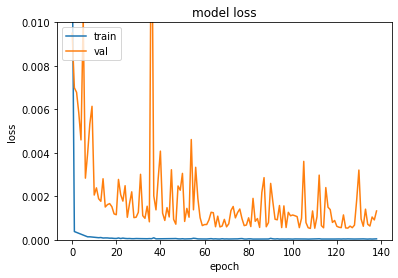

In [44]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.01])
plt.show()


<Strong> Second 3-Layer Model with <i> dilation_rate = 3 </i> and <i> kernel_size = 5 </i> </Strong>

In [34]:
def createModelThreeLayerSecond(hp):
    
    num_layers = 3

    hp_learning_rate = hp.Choice('learning_rate' , values = [0.002 , 0.004 , 0.006 , 0.008 , 0.01])
    hp_dense_layer = hp.Choice('dense_layer' , values = [16 , 32 , 64 , 128])
    hp_filters = hp.Choice ('filters' , values = [8 , 16 , 32])

    
    model = models.Sequential()
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))

    model.add(Conv1D(filters=32, kernel_size=5, activation='relu' , padding = 'causal', dilation_rate=3))

    model.add(Conv1D(filters=64, kernel_size=5, activation='relu' , padding = 'causal' , dilation_rate=9))
    
    model.add(Flatten())
    
    model.add(Dense(hp_dense_layer, activation='relu'))

    model.add(Dense(1))

    model.summary()
    
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=opt , loss = 'mse')
    
    return model
    

In [35]:
tuner = RandomSearch (
    createModelThreeLayerSecond,
    objective = "val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory = 'tcn',
    project_name='tcn_3_layers_second'
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 24, 32)            192       
                                                                 
 conv1d_4 (Conv1D)           (None, 24, 32)            5152      
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 64)            10304     
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                24592     
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 40,257
Trainable params: 40,257
Non-trai

In [36]:
tuner.search(btc_train[0] , btc_train[1] , epochs=300 , validation_data=btc_val , batch_size = 512 , callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)] )


Trial 22 Complete [00h 00m 39s]
val_loss: 0.0005882426048628986

Best val_loss So Far: 0.0005128354532644153
Total elapsed time: 00h 14m 25s
INFO:tensorflow:Oracle triggered exit


In [37]:
tuner.results_summary()

Results summary
Results in tcn/tcn_3_layers_second
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 16
filters: 32
Score: 0.0005128354532644153
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 64
filters: 16
Score: 0.0005251059192232788
Trial summary
Hyperparameters:
learning_rate: 0.008
dense_layer: 32
filters: 32
Score: 0.000525432697031647
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 32
filters: 16
Score: 0.0005339287454262376
Trial summary
Hyperparameters:
learning_rate: 0.01
dense_layer: 32
filters: 16
Score: 0.0005345743848010898
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 64
filters: 16
Score: 0.000538633787073195
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 16
filters: 16
Score: 0.0005447531584650278
Trial summary
Hyperparameters:
learning_rate: 0.01
dense_layer: 128
filters: 16
Score: 0.0005499249673448503
Trial summary

<Strong> Creating model and graphing results from tuner search. </Strong>

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 24, 32)            192       
                                                                 
 conv1d_7 (Conv1D)           (None, 24, 32)            5152      
                                                                 
 conv1d_8 (Conv1D)           (None, 24, 32)            5152      
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 16)                12304     
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 22,817
Trainable params: 22,817
Non-trai

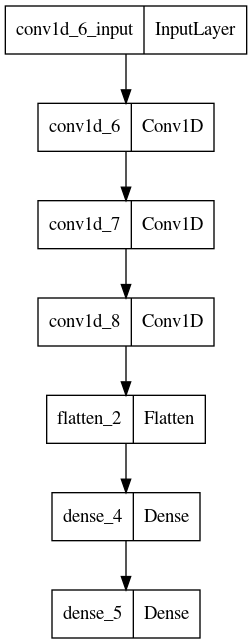

In [39]:

model = models.Sequential()

model.add(Conv1D(filters= 32, kernel_size=5, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))
model.add(Conv1D(filters= 32, kernel_size=5, activation='relu' , padding = 'causal', dilation_rate=3))
model.add(Conv1D(filters= 32, kernel_size=5, activation='relu' , padding = 'causal' , dilation_rate=9))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.summary()
display(plot_model(model))
    
opt = Adam(learning_rate=0.002)
model.compile(optimizer=opt , loss = 'mse')

In [40]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300
54/54 [==============================] - 1s 10ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 2/300
54/54 [==============================] - 0s 5ms/step - loss: 3.7939e-04 - val_loss: 0.0070
Epoch 3/300
54/54 [==============================] - 0s 5ms/step - loss: 3.3880e-04 - val_loss: 0.0068
Epoch 4/300
54/54 [==============================] - 0s 5ms/step - loss: 3.0324e-04 - val_loss: 0.0058
Epoch 5/300
54/54 [==============================] - 0s 5ms/step - loss: 2.5701e-04 - val_loss: 0.0046
Epoch 6/300
54/54 [==============================] - 0s 5ms/step - loss: 2.1646e-04 - val_loss: 0.0102
Epoch 7/300
54/54 [==============================] - 0s 5ms/step - loss: 1.7695e-04 - val_loss: 0.0028
Epoch 8/300
54/54 [==============================] - 0s 5ms/step - loss: 1.3727e-04 - val_loss: 0.0040
Epoch 9/300
54/54 [==============================] - 0s 5ms/step - loss: 1.3739e-04 - val_loss: 0.0053
Epoch 10/300
54/54 [==============================] - 0s 5ms/step - loss: 1.

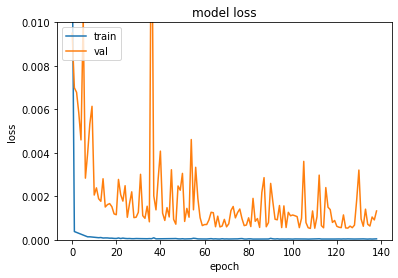

In [45]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.01])
plt.show()
